In [1]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 9.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 kB 1.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from itertools import count
%matplotlib inline

from gymnasium.wrappers.record_video import RecordVideo

In [4]:
import gymnasium as gym
from gymnasium.core import Wrapper
from pickle import dumps, loads
from collections import namedtuple

# a container for get_result function below. Works just like tuple, but prettier
ActionResult = namedtuple(
    "action_result",
    ("snapshot", "observation", "reward", "terminated", "truncated", "info")
)


class WithSnapshots(Wrapper):
    """
    Creates a wrapper that supports saving and loading environemnt states.
    Required for planning algorithms.

    This class will have access to the core environment as self.env, e.g.:
    - self.env.reset()           #reset original env
    - self.env.ale.cloneState()  #make snapshot for atari. load with .restoreState()
    - ...

    You can also use reset() and step() directly for convenience.
    - s, info = self.reset()                   # same as self.env.reset()
    - s, r, terminated, truncated, info = self.step(action)  # same as self.env.step(action)

    Note that while you may use self.render(), it will spawn a window that cannot be pickled.
    Thus, you will need to call self.close() before pickling will work again.
    """

    def get_snapshot(self, render=False):
        """
        :returns: environment state that can be loaded with load_snapshot
        Snapshots guarantee same env behaviour each time they are loaded.

        Warning! Snapshots can be arbitrary things (strings, integers, json, tuples)
        Don't count on them being pickle strings when implementing MCTS.

        Developer Note: Make sure the object you return will not be affected by
        anything that happens to the environment after it's saved.
        You shouldn't, for example, return self.env.
        In case of doubt, use pickle.dumps or deepcopy.

        """
        if render:
            self.render()  # close popup windows since we can't pickle them
            self.close()

        # if self.unwrapped.viewer is not None:
        #     self.unwrapped.viewer.close()
        #     self.unwrapped.viewer = None
        return dumps(self.env)

    def load_snapshot(self, snapshot, render=False):
        """
        Loads snapshot as current env state.
        Should not change snapshot inplace (in case of doubt, deepcopy).
        """

        assert not hasattr(self, "_monitor") or hasattr(
            self.env, "_monitor"), "can't backtrack while recording"

        if render:
            self.render()  # close popup windows since we can't load into them
            self.close()
        self.env = loads(snapshot)

    def step_with_snapshot(self, snapshot, action):
        """
        A convenience function that
        - loads snapshot,
        - commits action via self.step,
        - and takes snapshot again :)

        :returns: next snapshot, next_observation, reward, is_done, info

        Basically it returns next snapshot and everything that env.step would have returned.
        """

        # load, commit, take snapshot
        ####### Здесь ваш код ########
        self.load_snapshot(snapshot)
        next_observation, reward, terminated, truncated, info = self.step(action)
        next_snapshot = self.get_snapshot()
        ##############################

        return ActionResult(
            next_snapshot,
            next_observation,
            reward,
            terminated,
            truncated,
            info
        )

In [5]:
env_name = 'Taxi-v3'

In [6]:
#check snapshot
def test_snapshotting():
    # make env
    env = WithSnapshots(gym.make(env_name, max_episode_steps=100))
    env.reset()

    n_actions = env.action_space.n

    # create first snapshot
    snap0 = env.get_snapshot()
    action = env.action_space.sample()

    state, _, terminated, truncated, *_ = env.step(action)
    print(state, terminated, truncated)

    # play without making snapshots (faster)
    while True:
        if truncated:
            print("Whoops! We died!")
            break
        if terminated:
            print("Yay! You survived enough!")
            break
        _, _, terminated, truncated, _ = env.step(env.action_space.sample())

    env.reset()
    # reload initial state
    env.load_snapshot(snap0)

    state1, *_ = env.step(action)
    print(state1)
    assert np.all(state == state1)
    print('Load successful!')

test_snapshotting()

148 False False
Whoops! We died!
148
Load successful!


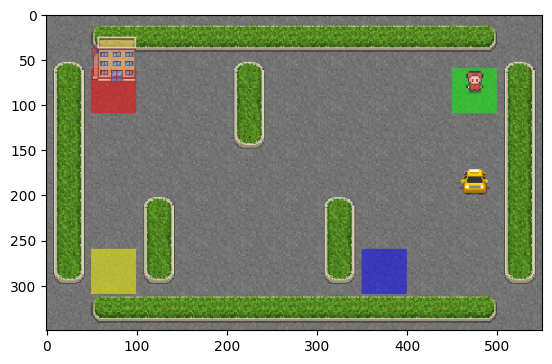

In [23]:
env = gym.make("Taxi-v3", render_mode="rgb_array", max_episode_steps=400)
env.reset(seed=87)
#print()
plt.imshow(env.render())

In [24]:
print(env.reset(seed = 42))

(386, {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)})


In [25]:
#import torch
def select_action_eps_greedy(Q, state, epsilon):
    """Выбирает действие epsilon-жадно."""
    Q_s = Q[state]
    if np.random.random() < epsilon:
        n_actions = Q_s.shape[-1]
        action = np.random.choice(n_actions)
    else:
        action = np.argmax(Q_s)
    action = int(action)
    return action


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


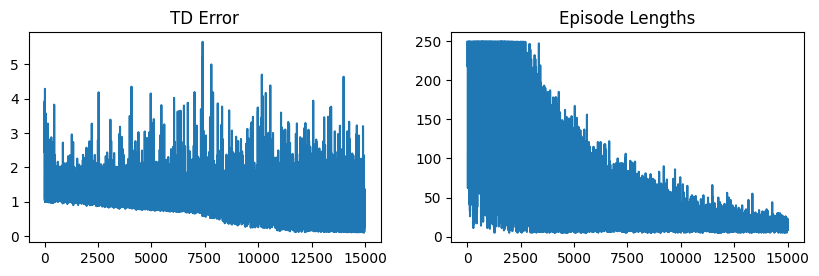

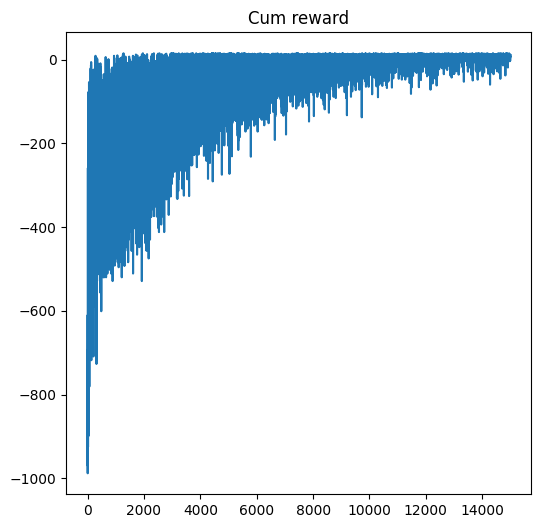

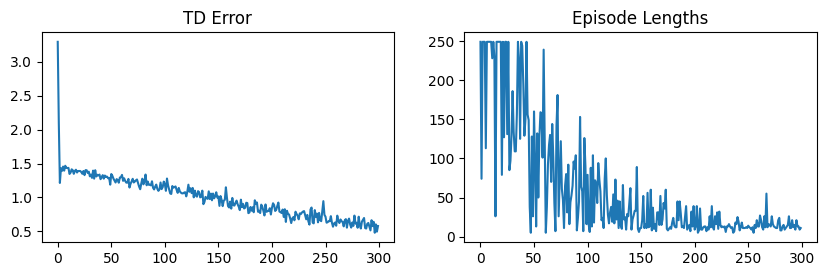

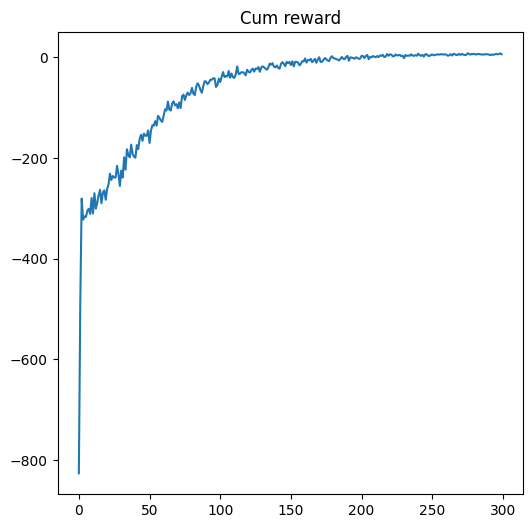

In [62]:
train_episode_length = 250
episodes = 15000
epsilon= 0.3
gamma = 0.95
lr = 0.01 #5e-2 #good version 5e-2

#agent = TabularSuccessorAgent(env.state_size, env.action_size, lr, gamma)

experiences = []
#test_experiences = []
#test_lengths = []
all_td_errors = []
all_cum_rewards = []
all_ep_length = []

batch_all_td_errors = []
batch_all_cum_rewards = []
batch_all_ep_length = []

Q=np.zeros((int(env.observation_space.n), int(env.action_space.n)))


batch_errs = []
batch_cum_rewards = []
batch_ep_len = []

episodes_step = 50

for i in range(episodes):
    #adjust epsilon:
    if i%1000 and (epsilon>1e-2):
      epsilon = epsilon/2
    # Train phase
    s, info = env.reset()
    episodic_error = []
    cum_ep_reward = 0
    a = select_action_eps_greedy(Q, s, epsilon=epsilon)
    for j in range(train_episode_length):
        s_next,r,terminated,truncated,info = env.step(a)
        cum_ep_reward += r
        a_next = select_action_eps_greedy(Q, s_next, epsilon=epsilon)
        done = terminated or truncated
        #experiences.append([s, a, s_next, r, done])
        #s = s_next
        if 1: #(j > 1):
            td_err = r+gamma*Q[s_next, a_next] - Q[s,a]
            Q[s, a] = Q[s, a] + lr * td_err
            episodic_error.append(np.mean(np.abs(td_err)))
        s = s_next
        ep_len = j
        if done:
            break
        #print(s)
        a = a_next

    batch_errs.append(np.mean(episodic_error))
    batch_cum_rewards.append(cum_ep_reward)
    batch_ep_len.append(ep_len)

    all_td_errors.append(np.mean(episodic_error))
    all_cum_rewards.append(cum_ep_reward)
    all_ep_length.append(ep_len)

    if i % episodes_step == 0:
        batch_all_td_errors.append(np.mean(batch_errs))
        batch_all_cum_rewards.append(np.mean(batch_cum_rewards))
        batch_all_ep_length.append(np.mean(ep_len))

        batch_errs = []
        batch_cum_rewards = []
        batch_ep_len = []



fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(2, 2, 1)
ax.plot(all_td_errors)
ax.set_title("TD Error")
ax = fig.add_subplot(2, 2, 2)
ax.plot(all_ep_length)
ax.set_title("Episode Lengths")

fig = plt.figure(figsize=(6, 6))
plt.title('Cum reward')
plt.plot(all_cum_rewards)


fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(2, 2, 1)
ax.plot(batch_all_td_errors)
ax.set_title("TD Error")
ax = fig.add_subplot(2, 2, 2)
ax.plot(batch_all_ep_length)
ax.set_title("Episode Lengths")

fig = plt.figure(figsize=(6, 6))
plt.title('Cum reward')
plt.plot(batch_all_cum_rewards)

In [89]:
#from IPython import show_video
#show_video('video/rl-video-episode-0.mp4')

from IPython.display import Video
Video('video/rl-video-episode-0.mp4')

In [66]:
def run_episode_for_recording(eps, Q):
  env=gym.make('Taxi-v3', render_mode='rgb_array', max_episode_steps=250)
  env=RecordVideo(env, './video')

  s, info = env.reset()
  terminated=False
  truncated=False
  timestamp=0 # number of actions
  states, actions, rewards= [],[],[] #вроде как просто для хранения
  a=select_action_eps_greedy(Q, s, eps)

  while timestamp<200 and terminated==False and truncated==False:
    s_next, r, terminated, truncated,_=env.step(a)
    states.append(s), actions.append(a), rewards.append(r)
    a_next = select_action_eps_greedy(Q, s, eps)

    td_err = r+gamma*Q[s_next, a_next] - Q[s,a]
    Q[s, a] = Q[s, a] + lr * td_err
    a_next=select_action_eps_greedy(Q, s, eps)

    s,a=s_next, a_next
    timestamp+=1
  env.close()

In [67]:
#env.close()
#env=gym.make('Taxi-v3', render_mode='rgb_array', max_episode_steps=250)
run_episode_for_recording(0.0, Q)
#env.close()

Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4


In [19]:
print(Q)

[[ 0.          0.          0.          0.          0.          0.        ]
 [-3.64301788 -3.62948491 -3.64057381 -3.62948491  5.20997639 -3.96517445]
 [-1.96351475 -1.95075357 -1.93144199 -1.95075357 10.9512375  -1.99251249]
 ...
 [-0.88112763 -0.8131483  -0.88112763 -0.91354473 -0.99875    -0.99875   ]
 [-2.040887   -2.05278099 -2.040887   -2.03424162 -2.48753121 -2.48753121]
 [-0.099875   -0.099875   -0.099875    0.07871906 -0.5        -0.5       ]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [65]:
run_episode_for_recording(0.0, Q)

Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4


SARSA-SR

In [ ]:
'''
train_episode_length = 5#50
test_episode_length = 5#50
episodes = 1 #2000
gamma = 0.95
lr = 5e-2
train_epsilon = 1.0
test_epsilon = 0.1

agent = TabularSuccessorAgent(env.state_size, env.action_size, lr, gamma)

experiences = []
test_experiences = []
test_lengths = []
lifetime_td_errors = []

for i in range(episodes):
    # Train phase
    agent_start = [0,0]
    if i < episodes // 2:
        goal_pos = [0, grid_size-1]
    else:
        if i == episodes // 2:
            print("\nSwitched reward locations")
        goal_pos = [grid_size-1,grid_size-1]
    env.reset(agent_pos=agent_start, goal_pos=goal_pos)
    state = env.observation
    episodic_error = []
    for j in range(train_episode_length):
        action = agent.sample_action(state, epsilon=train_epsilon)
        reward = env.step(action)
        state_next = env.observation
        #print('-----state----', state_next)
        done = env.done
        experiences.append([state, action, state_next, reward, done])
        state = state_next
        if (j > 1):
            td_sr = agent.update_sr(experiences[-2], experiences[-1])
            td_w = agent.update_w(experiences[-1])
            episodic_error.append(np.mean(np.abs(td_sr)))
        if env.done:
            td_sr = agent.update_sr(experiences[-1], experiences[-1])
            episodic_error.append(np.mean(np.abs(td_sr)))
            break
    lifetime_td_errors.append(np.mean(episodic_error))

    # Test phase
    env.reset(agent_pos=agent_start, goal_pos=goal_pos)
    state = env.observation
    for j in range(test_episode_length):
        action = agent.sample_action(state, epsilon=test_epsilon)
        reward = env.step(action)
        state_next = env.observation
        test_experiences.append([state, action, state_next, reward])
        state = state_next
        if env.done:
            break
    test_lengths.append(j)

    if i % 50 == 0:
        print('\rEpisode {}/{}, TD Error: {}, Test Lengths: {}'
              .format(i, episodes, np.mean(lifetime_td_errors[-50:]),
                      np.mean(test_lengths[-50:])), end='')

fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(2, 2, 1)
ax.plot(lifetime_td_errors)
ax.set_title("TD Error")
ax = fig.add_subplot(2, 2, 2)
ax.plot(test_lengths)
ax.set_title("Episode Lengths")
'''

'\ntrain_episode_length = 5#50\ntest_episode_length = 5#50\nepisodes = 1 #2000\ngamma = 0.95\nlr = 5e-2\ntrain_epsilon = 1.0\ntest_epsilon = 0.1\n\nagent = TabularSuccessorAgent(env.state_size, env.action_size, lr, gamma)\n\nexperiences = []\ntest_experiences = []\ntest_lengths = []\nlifetime_td_errors = []\n\nfor i in range(episodes):\n    # Train phase\n    agent_start = [0,0]\n    if i < episodes // 2:\n        goal_pos = [0, grid_size-1]\n    else:\n        if i == episodes // 2:\n            print("\nSwitched reward locations")\n        goal_pos = [grid_size-1,grid_size-1]\n    env.reset(agent_pos=agent_start, goal_pos=goal_pos)\n    state = env.observation\n    episodic_error = []\n    for j in range(train_episode_length):\n        action = agent.sample_action(state, epsilon=train_epsilon)\n        reward = env.step(action)\n        state_next = env.observation\n        #print(\'-----state----\', state_next)\n        done = env.done\n        experiences.append([state, action, sta

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


episode 0, mean_err 0.0018989616987179492
Episode 0/6000, TD Error: 0.0018989616987179492, Test Lengths: 199.0episode 1000, mean_err 0.001931411061350643
Episode 1000/6000, TD Error: 0.0019092415648329362, Test Lengths: 199.0episode 2000, mean_err 0.0020091893881129756
Episode 2000/6000, TD Error: 0.00200761407855209, Test Lengths: 199.0episode 3000, mean_err 0.002225562374059206
Episode 3000/6000, TD Error: 0.0021547613332027916, Test Lengths: 199.0episode 4000, mean_err 0.002341031678941552
Episode 4000/6000, TD Error: 0.0022985118910212464, Test Lengths: 199.0episode 5000, mean_err 0.0025656969916815634
Episode 5000/6000, TD Error: 0.0024446532417365134, Test Lengths: 199.0

Text(0.5, 1.0, 'Episode Lengths')

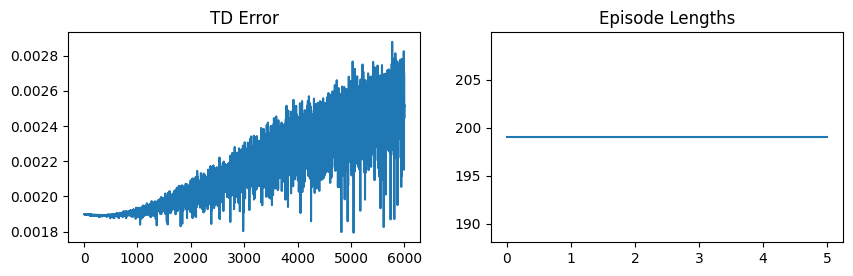

In [36]:
train_episode_length = 200
test_episode_length = 200
episodes = 6000
gamma = 0.95
lr = 5e-3
train_epsilon = 1.0
test_epsilon = 0.1

experiences = []
test_experiences = []
test_lengths = []
all_td_errors = []

#Q=np.zeros((int(env.observation_space.n), int(env.action_space.n)))
M = np.stack([np.identity(int(env.observation_space.n)) for i in range(int(env.action_space.n))])
#print(M.shape) 6*500*500
w = np.zeros([int(env.observation_space.n)])

def onehot(value, max_value):
    vec = np.zeros(max_value)
    vec[value] = 1
    return vec


def select_action_eps_greedy_SR(M, w,state, eps):
  if np.random.random()<eps:
    action=env.action_space.sample()
  else:
    Q_estimate = np.matmul(M[:,state,:],w)
    action=np.argmax(Q_estimate)
  return action


for i in range(episodes):
    # Train phase
    #agent_start = [0,0]
    s, info = env.reset()
    #print(i)
    episodic_error = []
    for j in range(train_episode_length):
        #SARSA
        a = select_action_eps_greedy_SR(M,w, s, eps =0.)
        #print(a)
        s_next,r,terminated,truncated,info = env.step(a)
        a_next = select_action_eps_greedy_SR(M, w, s_next, eps=0.)
        done = terminated or truncated
        experiences.append([s, a, s_next, r, done])
        if (j > 1):
            #update w
            error = r - w[s_next]
            w[s_next] += lr * error
            #update sr
            I = onehot(s, env.observation_space.n)
            if done:
                td_error = (I + gamma * onehot(s, env.observation_space.n) - M[a, s, :])
            else:
                td_error = (I + gamma * M[a_next, s_next, :] - M[a, s, :])
            M[a, s, :] += lr * td_error
            ####
            episodic_error.append(np.mean(np.abs(td_error)))
        if done:
            break
        s = s_next
        #print(s)
    all_td_errors.append(np.mean(episodic_error))

    # Test phase
    if i%1000 == 0:
      print(f'episode {i}, mean_err {np.mean(episodic_error)}')
      s, info = env.reset()
      for j in range(test_episode_length):
          a = select_action_eps_greedy_SR(M, w, s, eps=0.3)
          s_next,r,terminated,truncated,info = env.step(a)
          a_next = select_action_eps_greedy_SR(M, w, s_next, eps=0.)
          #print('-----state----', state_next)
          done = terminated or truncated
          test_experiences.append([s, a, s_next, r, done])
          ep_len = j
          if done:
              break
      test_lengths.append(ep_len)
      print('\rEpisode {}/{}, TD Error: {}, Test Lengths: {}'
              .format(i, episodes, np.mean(all_td_errors[-50:]),
                      np.mean(test_lengths[-50:])), end='')

fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(2, 2, 1)
ax.plot(all_td_errors)
ax.set_title("TD Error")
ax = fig.add_subplot(2, 2, 2)
ax.plot(test_lengths)
ax.set_title("Episode Lengths")

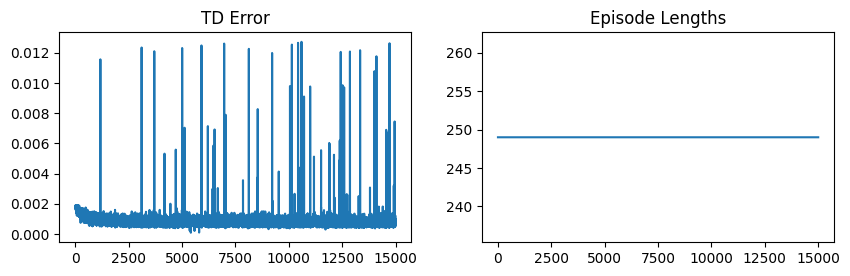

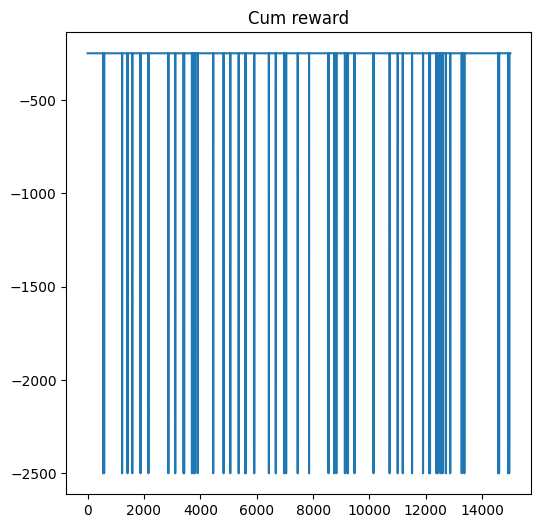

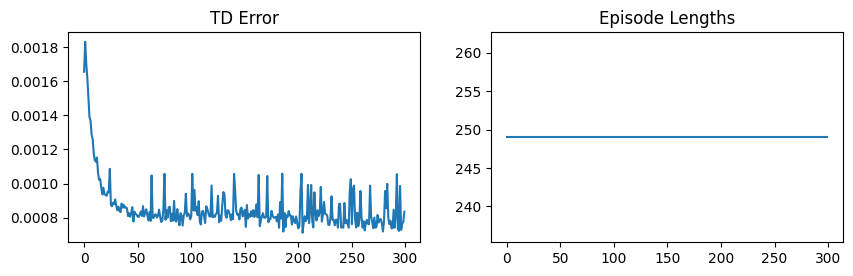

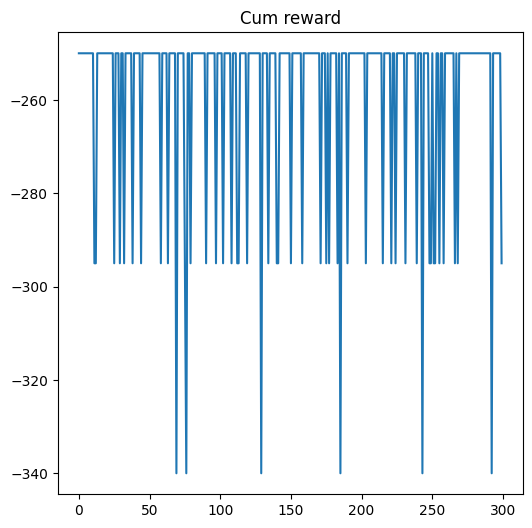

In [92]:
train_episode_length = 250
episodes = 15000
epsilon= 0.3
gamma = 0.95
lr = 0.01 #5e-2 #good version 5e-2

#agent = TabularSuccessorAgent(env.state_size, env.action_size, lr, gamma)

#M = np.stack([np.identity(int(env.observation_space.n)) for i in range(int(env.action_space.n))])
M = np.zeros((int(env.action_space.n), int(env.observation_space.n), int(env.observation_space.n)))
w = np.zeros([int(env.observation_space.n)])

def onehot(value, max_value):
    vec = np.zeros(max_value)
    vec[value] = 1
    return vec


def select_action_eps_greedy_SR(M, w,state, eps):
  if np.random.random()<eps:
    action=env.action_space.sample()
  else:
    Q_estimate = np.matmul(M[:,state,:],w)
    action=np.argmax(Q_estimate)
  return action

experiences = []
#test_experiences = []
#test_lengths = []
all_td_errors = []
all_cum_rewards = []
all_ep_length = []

batch_all_td_errors = []
batch_all_cum_rewards = []
batch_all_ep_length = []

Q=np.zeros((int(env.observation_space.n), int(env.action_space.n)))


batch_errs = []
batch_cum_rewards = []
batch_ep_len = []

episodes_step = 50

for i in range(episodes):
    #adjust epsilon:
    if i%1000 and (epsilon>1e-2):
      epsilon = epsilon/2
    # Train phase
    s, info = env.reset()
    episodic_error = []
    cum_ep_reward = 0
    a = select_action_eps_greedy(Q, s, epsilon=epsilon)
    for j in range(train_episode_length):
        s_next,r,terminated,truncated,info = env.step(a)
        cum_ep_reward += r
        a_next = select_action_eps_greedy(Q, s_next, epsilon=epsilon)
        done = terminated or truncated
        if 1: #(j > 1):
            #update w
            error = r - w[s_next]
            w[s_next] += lr * error
            #update sr
            I = onehot(s_next, env.observation_space.n) #s?
            td_error = (I + gamma *(1-done)* M[a_next, s_next, :] - M[a, s, :])
            M[a, s, :] += lr * td_error
            ####
            episodic_error.append(np.mean(np.abs(td_error)))
        s = s_next
        ep_len = j
        if done:
            break

    batch_errs.append(np.mean(episodic_error))
    batch_cum_rewards.append(cum_ep_reward)
    batch_ep_len.append(ep_len)

    all_td_errors.append(np.mean(episodic_error))
    all_cum_rewards.append(cum_ep_reward)
    all_ep_length.append(ep_len)

    if i % episodes_step == 0:
        batch_all_td_errors.append(np.mean(batch_errs))
        batch_all_cum_rewards.append(np.mean(batch_cum_rewards))
        batch_all_ep_length.append(np.mean(ep_len))

        batch_errs = []
        batch_cum_rewards = []
        batch_ep_len = []



fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(2, 2, 1)
ax.plot(all_td_errors)
ax.set_title("TD Error")
ax = fig.add_subplot(2, 2, 2)
ax.plot(all_ep_length)
ax.set_title("Episode Lengths")

fig = plt.figure(figsize=(6, 6))
plt.title('Cum reward')
plt.plot(all_cum_rewards)


fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(2, 2, 1)
ax.plot(batch_all_td_errors)
ax.set_title("TD Error")
ax = fig.add_subplot(2, 2, 2)
ax.plot(batch_all_ep_length)
ax.set_title("Episode Lengths")

fig = plt.figure(figsize=(6, 6))
plt.title('Cum reward')
plt.plot(batch_all_cum_rewards)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


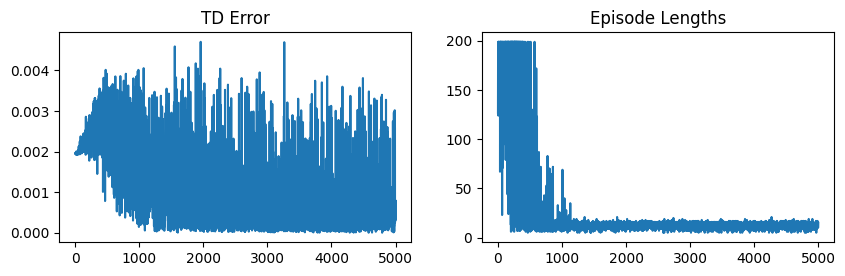

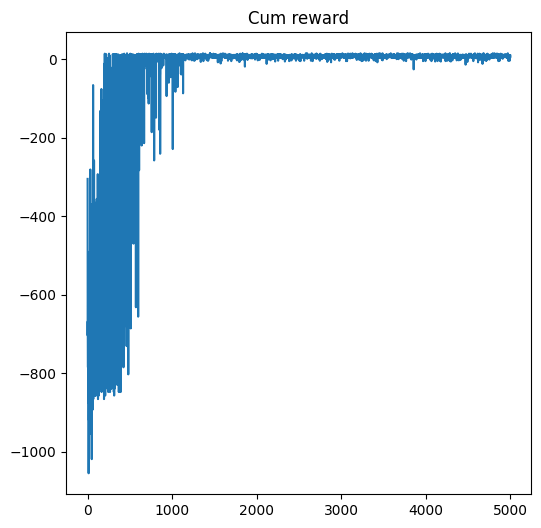

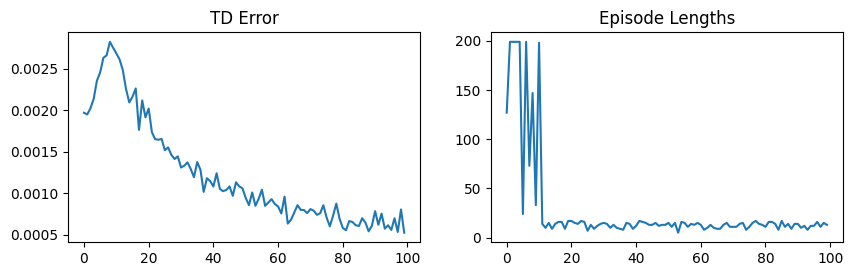

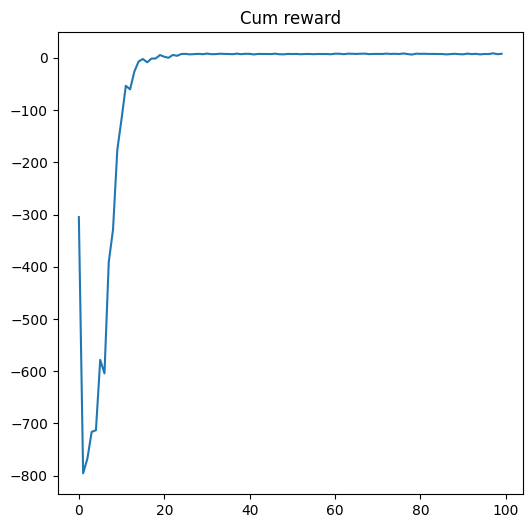

In [98]:
env=gym.make('Taxi-v3')
train_episode_length = 250
episodes = 5000
epsilon= 0.3
gamma = 0.95
lr = 0.1 #5e-2 #good version 5e-2

#agent = TabularSuccessorAgent(env.state_size, env.action_size, lr, gamma)

#M = np.stack([np.identity(int(env.observation_space.n)) for i in range(int(env.action_space.n))])
M = np.zeros((int(env.action_space.n), int(env.observation_space.n), int(env.observation_space.n)))
w = np.zeros([int(env.observation_space.n)])

def onehot(value, max_value):
    vec = np.zeros(max_value)
    vec[value] = 1
    return vec


def select_action_eps_greedy_SR(M, w,state, eps):
  if np.random.random()<eps:
    action=env.action_space.sample()
  else:
    Q_estimate = np.matmul(M[:,state,:],w)
    action=np.argmax(Q_estimate)
  return action

experiences = []
#test_experiences = []
#test_lengths = []
all_td_errors = []
all_cum_rewards = []
all_ep_length = []

batch_all_td_errors = []
batch_all_cum_rewards = []
batch_all_ep_length = []

batch_errs = []
batch_cum_rewards = []
batch_ep_len = []

episodes_step = 50

for i in range(episodes):
    #adjust epsilon:
    if i%1000 and (epsilon>1e-2):
      epsilon = epsilon/2
    # Train phase
    s, info = env.reset()
    episodic_error = []
    cum_ep_reward = 0
    a = select_action_eps_greedy_SR(M,w, s, eps=epsilon)
    for j in range(train_episode_length):
        s_next,r,terminated,truncated,info = env.step(a)
        cum_ep_reward += r
        a_next = select_action_eps_greedy_SR(M, w, s_next, eps=epsilon)
        done = terminated or truncated
        if 1: #(j > 1):
            #update w
            error = r - w[s_next]
            w[s_next] += lr * error
            #update sr
            td_error = gamma *(1-done)* M[a_next, s_next, :] - M[a, s, :]
            td_error[s_next] += 1.0
            M[a, s, :] += lr * td_error
            ####
            episodic_error.append(np.mean(np.abs(td_error)))
        s = s_next
        a = a_next
        ep_len = j
        if done:
            break

    batch_errs.append(np.mean(episodic_error))
    batch_cum_rewards.append(cum_ep_reward)
    batch_ep_len.append(ep_len)

    all_td_errors.append(np.mean(episodic_error))
    all_cum_rewards.append(cum_ep_reward)
    all_ep_length.append(ep_len)

    if i % episodes_step == 0:
        batch_all_td_errors.append(np.mean(batch_errs))
        batch_all_cum_rewards.append(np.mean(batch_cum_rewards))
        batch_all_ep_length.append(np.mean(ep_len))

        batch_errs = []
        batch_cum_rewards = []
        batch_ep_len = []



fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(2, 2, 1)
ax.plot(all_td_errors)
ax.set_title("TD Error")
ax = fig.add_subplot(2, 2, 2)
ax.plot(all_ep_length)
ax.set_title("Episode Lengths")

fig = plt.figure(figsize=(6, 6))
plt.title('Cum reward')
plt.plot(all_cum_rewards)


fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(2, 2, 1)
ax.plot(batch_all_td_errors)
ax.set_title("TD Error")
ax = fig.add_subplot(2, 2, 2)
ax.plot(batch_all_ep_length)
ax.set_title("Episode Lengths")

fig = plt.figure(figsize=(6, 6))
plt.title('Cum reward')
plt.plot(batch_all_cum_rewards)

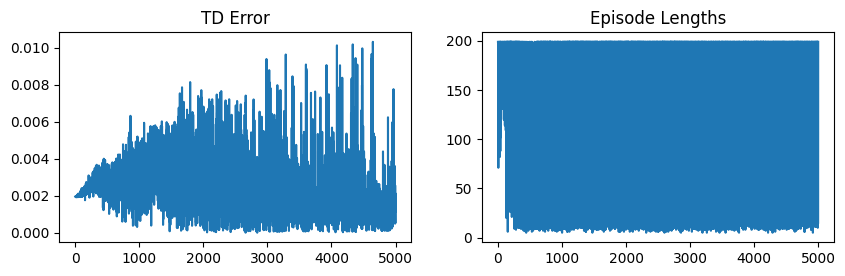

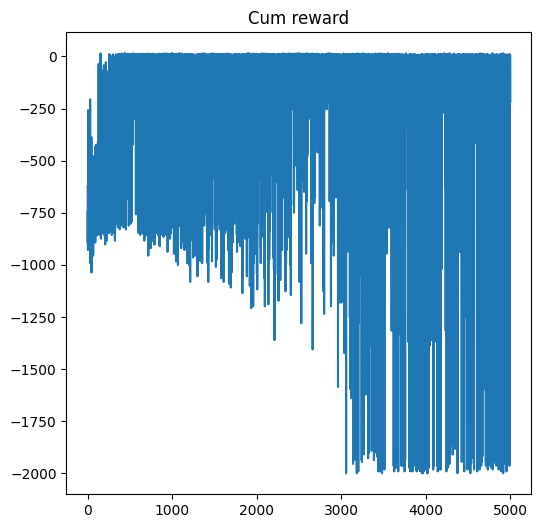

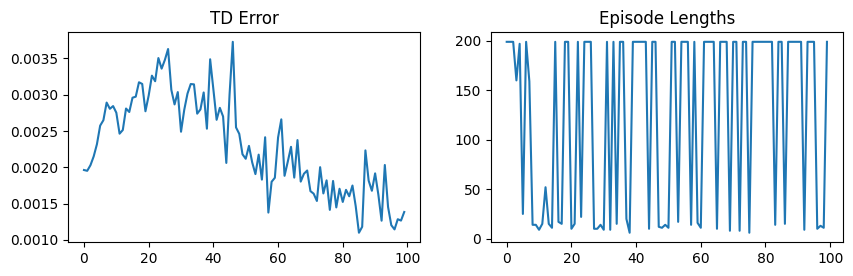

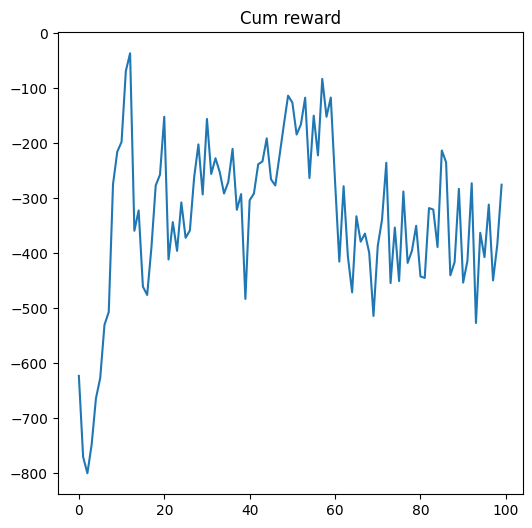

In [104]:
env=gym.make('Taxi-v3')
train_episode_length = 250
episodes = 5000
epsilon= 0.3
gamma = 0.95
lr = 0.1 #5e-2 #good version 5e-2

#agent = TabularSuccessorAgent(env.state_size, env.action_size, lr, gamma)

#M = np.stack([np.identity(int(env.observation_space.n)) for i in range(int(env.action_space.n))])
M = np.zeros((int(env.action_space.n), int(env.observation_space.n), int(env.observation_space.n)))
w = np.zeros([int(env.observation_space.n)])

def onehot(value, max_value):
    vec = np.zeros(max_value)
    vec[value] = 1
    return vec


def select_action_eps_greedy_SR(M, w,state, eps):
  if np.random.random()<eps:
    action=env.action_space.sample()
  else:
    Q_estimate = np.matmul(M[:,state,:],w)
    action=np.argmax(Q_estimate)
  return action

experiences = []
#test_experiences = []
#test_lengths = []
all_td_errors = []
all_cum_rewards = []
all_ep_length = []

batch_all_td_errors = []
batch_all_cum_rewards = []
batch_all_ep_length = []

batch_errs = []
batch_cum_rewards = []
batch_ep_len = []

episodes_step = 50

for i in range(episodes):
    #adjust epsilon:
    if i%1000 and (epsilon>1e-2):
      epsilon = epsilon/2
    # Train phase
    s, info = env.reset()
    episodic_error = []
    cum_ep_reward = 0
    a = select_action_eps_greedy_SR(M,w, s, eps=epsilon)
    for j in range(train_episode_length):
        s_next,r,terminated,truncated,info = env.step(a)
        cum_ep_reward += r
        a_next = select_action_eps_greedy_SR(M, w, s_next, eps=epsilon)
        done = terminated or truncated
        if 1: #(j > 1):
            #update w
            error = r - w[s]
            w[s_next] += lr * error
            #update sr
            td_error = gamma *(1-done)* M[a_next, s_next, :] - M[a, s, :]
            td_error[s_next] += 1.0
            M[a, s, :] += lr * td_error
            ####
            episodic_error.append(np.mean(np.abs(td_error)))
        s = s_next
        a = a_next
        ep_len = j
        if done:
            break

    batch_errs.append(np.mean(episodic_error))
    batch_cum_rewards.append(cum_ep_reward)
    batch_ep_len.append(ep_len)

    all_td_errors.append(np.mean(episodic_error))
    all_cum_rewards.append(cum_ep_reward)
    all_ep_length.append(ep_len)

    if i % episodes_step == 0:
        batch_all_td_errors.append(np.mean(batch_errs))
        batch_all_cum_rewards.append(np.mean(batch_cum_rewards))
        batch_all_ep_length.append(np.mean(ep_len))

        batch_errs = []
        batch_cum_rewards = []
        batch_ep_len = []



fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(2, 2, 1)
ax.plot(all_td_errors)
ax.set_title("TD Error")
ax = fig.add_subplot(2, 2, 2)
ax.plot(all_ep_length)
ax.set_title("Episode Lengths")

fig = plt.figure(figsize=(6, 6))
plt.title('Cum reward')
plt.plot(all_cum_rewards)


fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(2, 2, 1)
ax.plot(batch_all_td_errors)
ax.set_title("TD Error")
ax = fig.add_subplot(2, 2, 2)
ax.plot(batch_all_ep_length)
ax.set_title("Episode Lengths")

fig = plt.figure(figsize=(6, 6))
plt.title('Cum reward')
plt.plot(batch_all_cum_rewards)

In [70]:
print(Q)
print(Q.shape)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
(500, 6)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [86]:
#print(M*w)
Q_sr = M@w
print(M@w)
print(np.mean(Q_sr))
print(Q_sr.shape)

[[ 0.         -0.74964405 -0.91400734 ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
-2.0830872190555008
(6, 500)


In [74]:
print(w, w.shape)

[ 0.          0.          0.         -0.99329611 -0.91894148  0.
 -0.91894148 -0.91894148 -9.18941484 -0.99329611  0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -9.18204588  0.          0.         -9.18941484  0.
  0.          0.          0.          0.         -0.91812271  0.
  0.         -0.99315999 -0.91729567  0.         -0.99302111  0.
  0.          0.          0.          0.          0.         -1.6698597
  0.         -0.91894148 -0.91812271  0.         -0.91729567  0.
 -9.18941484 -0.91894148  0.         -9.18941484 -9.18941484 -9.18941484
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.91729567 -0.91729567 -9.10752069  0.
  0.          0.         -0.01       -9.18941484  0.         -0.91729567
 -0.91646027  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.99322839
 -0.91646027  0.          0.          0.         -0.9181227

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [100]:
run_episode_for_recording(0.0, (M@w).T)

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:297: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(


Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4


In [ ]:
#ipython.display clear_output

In [103]:
from IPython.display import Video
display(Video('video/rl-video-episode-0.mp4', embed=True))